In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import string
import requests
import io
from zipfile import ZipFile
from tensorflow.contrib import learn 
sess = tf.Session()
%matplotlib inline

In [11]:
save_file_name = os.path.join('smsspamcollection','SMSSpamCollection.csv')
if os.path.isfile(save_file_name):
    text_data = []
    with open(save_file_name, 'r') as temp_output_file:
        reader = csv.reader(temp_output_file)
        for row in reader:
            text_data.append(row)
else:
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    #Format Data
    text_data = file.decode()
    text_data = text_data.encode('ascii',errors='ignore')
    text_data = text_data.decode().split('\n')
    text_data = [x.split('\t') for x in text_data if len(x)>=1]
    
    #And write to csv
    with open(save_file_name, 'w') as temp_output_file:
        writer = csv.writer(temp_output_file)
        writer.writerows(text_data)
texts = [x[1] for x in text_data]
target = [x[0] for x in text_data]
#Relabel 'spam' as 1 'ham' as 0
target = [1 if x=='spam' else 0 for x in target]

In [14]:
#To reduce the potential vocabulary size, we normalize the text. To do this, we remove the influence of capitalization
#and numbers in the text. 

#Convert to lower case
texts = [x.lower() for x in texts]
#Remove punctuation
texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]
#Remove numbers
texts = [''.join(c for c in x if c not in '0123456789') for x in texts]
#Trim extra whitespace 
texts = [' '.join(x.split()) for x in texts]

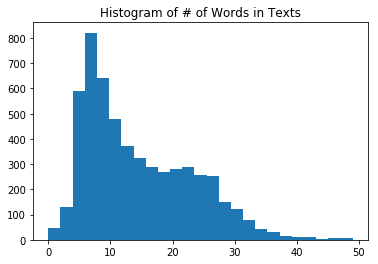

In [15]:
#We must also determine the maximum sentence size. To do this, we look at a histogram of text lenghts in the data set.
#We see that a good cut-off might be around 25 words. 

#Plot histogram of text lengths 
text_lengths = [len(x.split()) for x in texts]
text_lengths = [x for x in text_lengths if x < 50]
plt.hist(text_lengths, bins=25)
plt.title('Histogram of # of Words in Texts')
sentence_size = 25
min_word_freq = 3

In [18]:
#TensorFlow has a built-in processing tool for determining vocabulary embedding, called VocabularyProcessor(), under the
#learn.processing library
vocab_processor = learn.preprocessing.VocabularyProcessor(sentence_size, min_frequency=min_word_freq)
vocab_processor.fit_transform(texts)
embedding_size = len(vocab_processor.vocabulary_)

In [19]:
#Now we will split the data into a train and test set
train_indices = np.random.choice(len(texts), round(len(texts)*0.8),replace=False)
test_indices = np.array(list(set(range(len(texts))) - set(train_indices)))
texts_train = [x for ix, x in enumerate(texts) if ix in train_indices]
texts_test = [x for ix, x in enumerate(texts) if ix in test_indices]
target_train = [x for ix, x in enumerate(target) if ix in train_indices]
target_test = [x for ix, x in enumerate(target) if ix in test_indices]

In [20]:
#Now we declare the embedding matrix for the words. Sentence words will be translated into indices. These indices will be
#translated into one-hot encoded vectors that we can create with an identity matrix, which will be the size of our word
#embeddings. We will use this matrix to look up the sparse vector for each word and add them together for the sparse
#sentence vector. 
identitiy_mat = tf.diag(tf.ones(shape=[embedding_size]))

In [25]:
#Since we will end up doing logistic regression to predict the probability of spam, we need to declare our logistic 
#regression variables. Then we declare our data placeholders as well. It is important to note that the x_data input 
#placeholder should be of integer type because it will be used to look up the row index of our identity matrix and 
#TensorFlow requires that lookup to be an integer
A = tf.Variable(tf.random_normal(shape=[embedding_size,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))
#Initialize placeholders
x_data = tf.placeholder(shape=[sentence_size], dtype=tf.int32)
y_target = tf.placeholder(shape=[1,1], dtype=tf.float32)

In [26]:
#Now we use TensorFlow's embedding lookup function that will map the indices of the words in the sentence to the one-hot
#encoded vectors of our identity matrix. When we have that matrix, we create the sentence vector by summing up the 
#aforementioned word vectors. 
x_embed = tf.nn.embedding_lookup(identitiy_mat, x_data)
x_cool_sums = tf.reduce_sum(x_embed,0)

In [27]:
#Now that we have our fixed-length sentece vectors for each sentence, we want to perform logistic regression. To do this,
#we will need to declare the actual model operations. Since we are doing this one data point at a time (stochastic
#training), we will expand the dimensions of our input and perform linear regression operations on it. Remember that
#TensorFlow has a loss function that includes the sigmoid function, so we do not need to include it in our output here
x_col_sums_2D = tf.expand_dims(x_cool_sums,0)
model_output = tf.add(tf.matmul(x_col_sums_2D,A),b)

In [28]:
#We now declare the loss function, prediction operation, and optimization function for training the model. 
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_target, logits=model_output))
#Predictions operation
prediction = tf.sigmoid(model_output)
#Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.001)
train_step = my_opt.minimize(loss)

In [30]:
#Next we initialize our graph variables before we start the training generations:
init = tf.global_variables_initializer()
sess.run(init)

In [32]:
#Now we start the iteration over the sentences. TensorFlow's vocab_processor.fit() function is a generator that operates
#one sentence at a time. We will use this to our advantage to do stochastic training on our logistic model. To get a 
#better idea of the accuracy trend, we keep a trailing average of the past 50 training steps. If we just plotted the 
#current one, we would either see 1 or 0 depending on whether we predicted that training data point currently or not.
loss_vec = []
train_acc_all = []
train_acc_avg = []
for ix, t in enumerate(vocab_processor.fit_transform(texts_train)):
    y_data = [[target_train[ix]]]
    
    sess.run(train_step, feed_dict={x_data:t,y_target:y_data})
    
    temp_loss = sess.run(loss, feed_dict={x_data:t, y_target:y_data})
    loss_vec.append(temp_loss)
    
    if(ix+1)%10==0:
        print('Training Observation #' + str(ix+1) + 'Loss = ' + str(temp_loss))
        
        #Keep trailing average of past 50 observations accuracy
        #Get prediction of single observation 
        [[temp_pred]] = sess.run(prediction, feed_dict={x_data:t, y_target:y_data})
        #Get True/False if prediction is accurate
        train_acc_temp = target_train[ix]==np.round(temp_pred)
        train_acc_all.append(train_acc_temp)
        if len(train_acc_all) >=50:
            train_acc_avg.append(np.mean(train_acc_all[-50]))

Training Observation #10Loss = 1.4222957e-07
Training Observation #20Loss = 8.321655e-17
Training Observation #30Loss = 3.818709e-15
Training Observation #40Loss = 0.0068280175
Training Observation #50Loss = 8.7791365e-16
Training Observation #60Loss = 1.2487995e-16
Training Observation #70Loss = 4.320438e-21
Training Observation #80Loss = 0.00157549
Training Observation #90Loss = 7.6291503e-06
Training Observation #100Loss = 9.835172e-15
Training Observation #110Loss = 3.1028654e-19
Training Observation #120Loss = 4.3921784e-05
Training Observation #130Loss = 5.3654784e-14
Training Observation #140Loss = 3.8060903e-20
Training Observation #150Loss = 2.4353179e-08
Training Observation #160Loss = 2.730738
Training Observation #170Loss = 6.011515e-18
Training Observation #180Loss = 1.06044495e-16
Training Observation #190Loss = 3.631601e-21
Training Observation #200Loss = 2.9936177e-20
Training Observation #210Loss = 3.300642
Training Observation #220Loss = 7.0960986e-15
Training Observa

Training Observation #2050Loss = 9.314356
Training Observation #2060Loss = 4.5306003e-08
Training Observation #2070Loss = 0.00018066195
Training Observation #2080Loss = 3.9973664e-05
Training Observation #2090Loss = 0.00024359321
Training Observation #2100Loss = 5.8520723e-06
Training Observation #2110Loss = 4.5827317e-05
Training Observation #2120Loss = 3.1245367e-05
Training Observation #2130Loss = 0.0017744129
Training Observation #2140Loss = 9.4486177e-07
Training Observation #2150Loss = 1.6634052e-05
Training Observation #2160Loss = 0.037913173
Training Observation #2170Loss = 2.6710384
Training Observation #2180Loss = 1.0150502
Training Observation #2190Loss = 1.714957e-05
Training Observation #2200Loss = 0.00013392122
Training Observation #2210Loss = 8.559434e-06
Training Observation #2220Loss = 3.9264945e-05
Training Observation #2230Loss = 1.3204034e-05
Training Observation #2240Loss = 0.19104438
Training Observation #2250Loss = 0.0152364625
Training Observation #2260Loss = 0.

Training Observation #4010Loss = 0.016467514
Training Observation #4020Loss = 0.031168135
Training Observation #4030Loss = 0.0053419736
Training Observation #4040Loss = 0.0014103227
Training Observation #4050Loss = 0.00015734584
Training Observation #4060Loss = 2.2111783
Training Observation #4070Loss = 0.025554061
Training Observation #4080Loss = 0.0015287985
Training Observation #4090Loss = 5.8228326
Training Observation #4100Loss = 0.000100050784
Training Observation #4110Loss = 1.3144858e-05
Training Observation #4120Loss = 0.0011448958
Training Observation #4130Loss = 0.017944109
Training Observation #4140Loss = 0.00048120637
Training Observation #4150Loss = 7.1171424e-05
Training Observation #4160Loss = 1.827994
Training Observation #4170Loss = 0.00014997729
Training Observation #4180Loss = 0.044045504
Training Observation #4190Loss = 0.00039817183
Training Observation #4200Loss = 0.0012390119
Training Observation #4210Loss = 0.00092549523
Training Observation #4220Loss = 0.02603

In [33]:
#To get the test set accuracy, we repeat the preceding process, but only on the prediction operation, not the training 
#operation with the test texts:
print('Getting Test Set Accuracy')
test_acc_all = []
for ix, t in enumerate(vocab_processor.fit_transform(texts_test)):
    y_data = [[target_test[ix]]]
    
    if(ix+1)%50==0:
        print('Test Observation #' + str(ix+1))
        
    #Keep trailing average of past 50 observations accuracy
    #Get prediction of single observation
    [[temp_pred]] = sess.run(prediction, feed_dict={x_data:t,y_target:y_data})
    #Get True/False if prediction is accurate
    test_acc_temp = target_test[ix]==np.round(temp_pred)
    test_acc_all.append(test_acc_temp)
print('\nOverall Test Accuracy: {}'.format(np.mean(test_acc_all)))

Getting Test Set Accuracy
Test Observation #50
Test Observation #100
Test Observation #150
Test Observation #200
Test Observation #250
Test Observation #300
Test Observation #350
Test Observation #400
Test Observation #450
Test Observation #500
Test Observation #550
Test Observation #600
Test Observation #650
Test Observation #700
Test Observation #750
Test Observation #800
Test Observation #850
Test Observation #900
Test Observation #950
Test Observation #1000
Test Observation #1050
Test Observation #1100

Overall Test Accuracy: 0.8278026905829596
